In [41]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

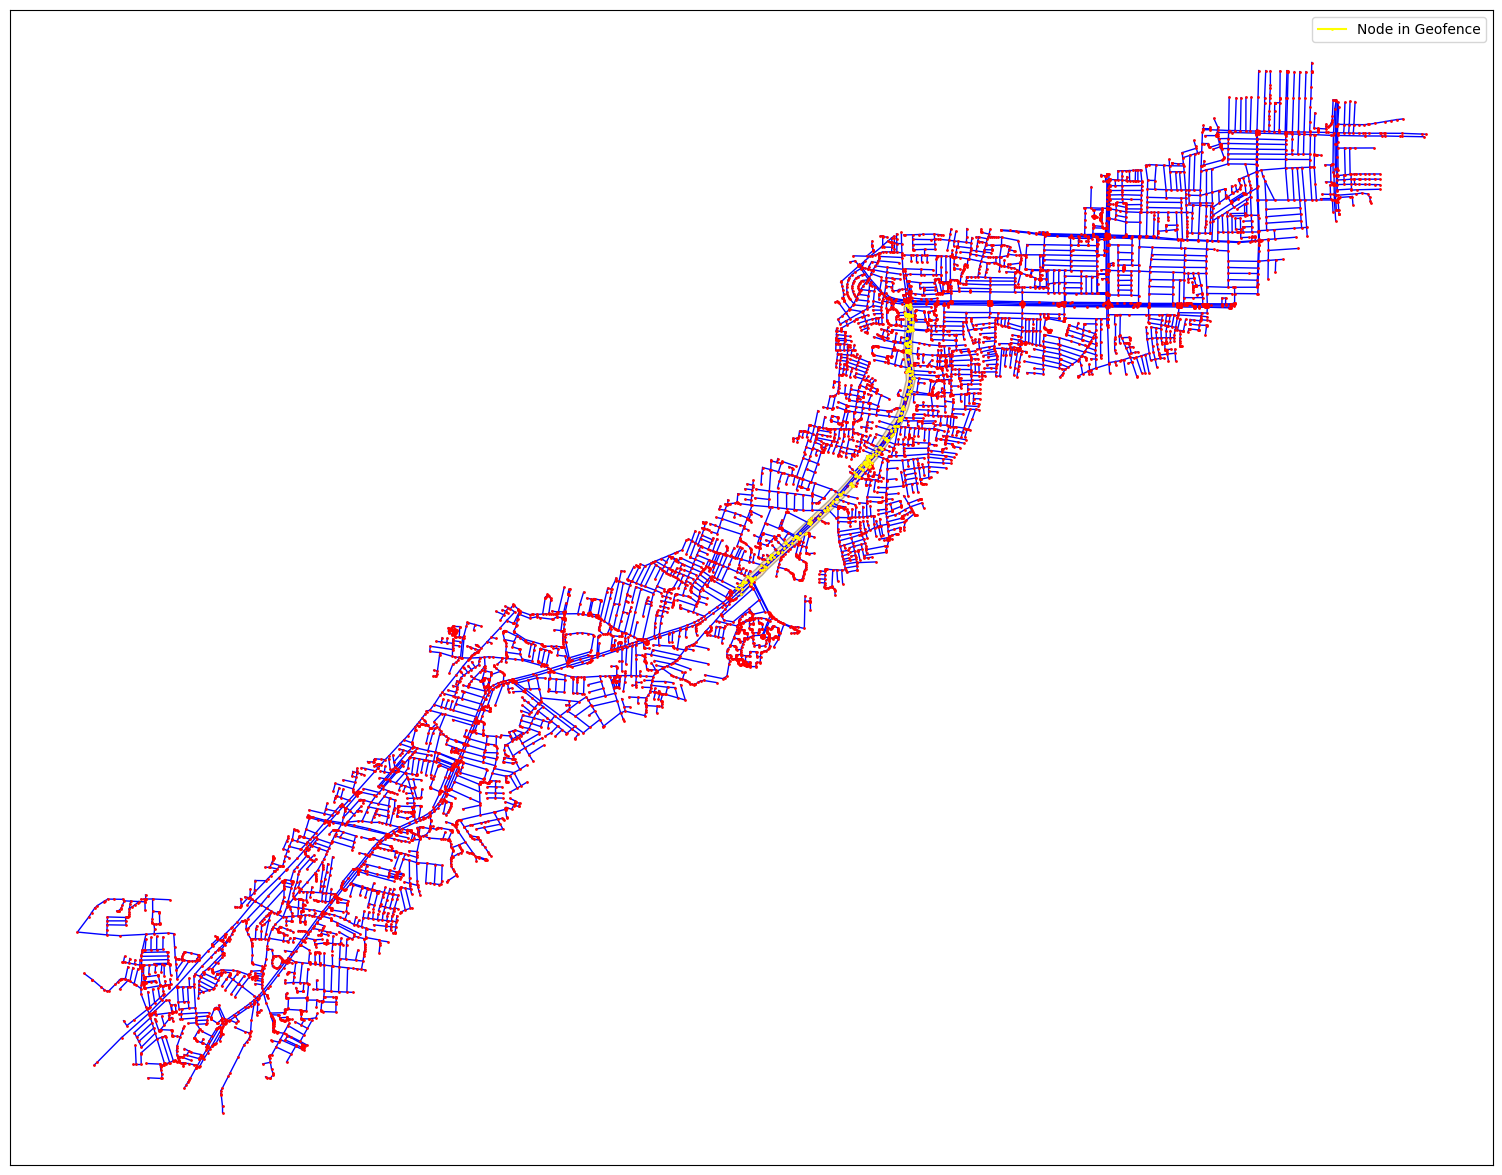

298
[(77.5712474, 12.8971694), (77.5680628, 12.8937679), (77.567978, 12.8938215), (77.5729151, 12.9000287), (77.5728748, 12.9000372), (77.5728476, 12.9000432), (77.5726766, 12.8994713), (77.5727056, 12.8994661), (77.572725, 12.8994627), (77.5728426, 12.8994404), (77.5733708, 12.9033965), (77.5733172, 12.903402), (77.5684039, 12.8941406), (77.5661704, 12.8922074), (77.5662185, 12.8921812), (77.5625268, 12.8890751), (77.571427, 12.8976759), (77.5714831, 12.8976559), (77.5727836, 12.8993205), (77.5728421, 12.8993099), (77.5725886, 12.8989754), (77.5726095, 12.8989648), (77.5726397, 12.8989494), (77.569016, 12.8947554), (77.5689505, 12.8948266), (77.5733689, 12.9062076), (77.573379, 12.9060935), (77.5733904, 12.9057294), (77.5733921, 12.9056745), (77.5733935, 12.905629), (77.5733867, 12.9053094), (77.5733806, 12.9050189), (77.5733699, 12.9048715), (77.5733666, 12.9048253), (77.5733525, 12.9047258), (77.5732952, 12.9041039), (77.5732827, 12.9038568), (77.5732862, 12.9035697), (77.5734348, 1

In [42]:
fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for i, node in enumerate(G.nodes()):
    G.nodes[node]['shapefile_index'] = i

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 59
end_index_2 = 120
observations_2 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_2 <= i < end_index_2:
                observations_2.append((point.longitude, point.latitude))

observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    states_in_geofence_2 = []
    for node, position in pos_2.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_2.append(position)

    fig, ax = plt.subplots(figsize=(30, 15))

    for edge in subgraph_2.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_2, pos_2, ax=ax, node_size=1, node_color='red')

    for point in observations_2_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='purple', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_2:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_2))
    print(states_in_geofence_2)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
total_geodesic_distance_km_2 = calculate_geodesic_distance(gpx_coordinates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_2:.2f} km")

print(len(observations_2_no_duplicates))
print(observations_2_no_duplicates)

In [43]:
observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_2_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.5626279, 12.8890332), (77.5632832, 12.8897687), (77.5632832, 12.8897687), (77.5632832, 12.8897687), (77.5634669, 12.8897121), (77.5639838, 12.8901688), (77.5642581, 12.8902724), (77.5647182, 12.8908751), (77.565162, 12.8912551), (77.5662185, 12.8921812), (77.5672158, 12.8930932), (77.5676394, 12.8933273), (77.5676827, 12.8932992), (77.5677734, 12.8936268), (77.5684039, 12.8941406), (77.5695249, 12.8946838), (77.5699144, 12.8959269), (77.5706069, 12.8965301), (77.5709343, 12.8970607), (77.5710801, 12.8972311), (77.5712521, 12.8974278), (77.571427, 12.8976759), (77.5714831, 12.8976559), (77.5717069, 12.8983128), (77.5721843, 12.8986905), (77.5721843, 12.8986905), (77.5726181, 12.8992526), (77.5729534, 12.900149), (77.573057, 12.9006349), (77.573057, 12.9006349), (77.573057, 12.9006349), (77.5731848, 12.9009316), (77.5731848, 12.9009316), (77.57337, 12.9016975), (77.5733018, 12.9025007), (77.5732652, 12.9030508), (77.5732652, 12.9030508), (77.5732018, 1

In [44]:
def swap_coordinates(array):
    return [(lat, lon) for lon, lat in array]
observations_2_swapped = swap_coordinates(observations_2_no_duplicates)
states_in_geofence_2_swapped = swap_coordinates(states_in_geofence_2)
closest_nodes_to_observations_swapped = swap_coordinates(closest_nodes_to_observations)
print("observations_1_swapped:", observations_2_swapped) 
print("states_in_geofence_1_swapped:", states_in_geofence_2_swapped)
print("closest_nodes_to_observations swapped:", closest_nodes_to_observations_swapped)

observations_1_swapped: [(12.8888895, 77.5626794), (12.8895857, 77.5632659), (12.8895632, 77.5632643), (12.8895762, 77.5633062), (12.8897289, 77.5634869), (12.8900951, 77.5639271), (12.8904018, 77.5642104), (12.8908263, 77.5646703), (12.8913378, 77.5652602), (12.8921839, 77.5662051), (12.8931738, 77.567294), (12.8933442, 77.5674692), (12.8935385, 77.5676682), (12.8936571, 77.5678062), (12.8942554, 77.5684626), (12.8953043, 77.5694723), (12.8958194, 77.5699361), (12.8966086, 77.5706026), (12.8969846, 77.5709194), (12.8972236, 77.5711258), (12.8974544, 77.5713273), (12.8975667, 77.571395), (12.8976717, 77.5714695), (12.8979862, 77.5716913), (12.8985538, 77.5720731), (12.898686, 77.5721387), (12.8992608, 77.5725835), (12.900105, 77.5729617), (12.9003855, 77.5730441), (12.9004118, 77.5730495), (12.9005152, 77.5730685), (12.9008064, 77.5731577), (12.9008923, 77.5731818), (12.9017745, 77.57339), (12.9027152, 77.5733183), (12.9032654, 77.5732393), (12.9032694, 77.5732459), (12.9032914, 77.573

In [45]:
score = None
pred = None
shapefile_indices = None
IT = None

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for idx, line in enumerate(data.geometry):
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = geodesic(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]), shapefile_index=idx)
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]), shapefile_index=idx)
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_2):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = geodesic(observations[k], observations[k + 1]).meters
        route_distance = state_distances_2[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(f"Beta value: {beta}")
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    print(sigz)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    return EMIS

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    global score, pred, IT
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1])
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_2 = np.array(observations_2_no_duplicates)
s = np.array(states_in_geofence_2)
s_2 = np.array(closest_nodes_to_observations)
zVec_2 = [geodesic(obs_2[i], obs_2[i + 1]).meters for i in range(len(obs_2) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_2 = calculate_graph_distances(G, s_2)
PRIOR_2 = np.ones(len(states_in_geofence_2)) / len(states_in_geofence_2)
matched_states_2 = viterbi_algorithm(states_in_geofence_2, obs_2, zVec_2, PRIOR_2, state_distances)
gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
total_geodesic_distance_km_2 = calculate_geodesic_distance(gpx_coordinates)
print(matched_states_2)
matched_coords = [states_in_geofence_2[i] for i in matched_states_2]
matched_shapefile_indices = [G.nodes[tuple(coord)]['shapefile_index'] for coord in matched_coords]
print("Matched shapefile indices:", matched_shapefile_indices)

Beta value: 24.83183626739715
7.70905512142901
[258 291 291 291 119 252 146 106 148  14 155  68 140 140  12  61  59  58
  54  97 116  16  17 192 117 117 168 170 194 194 171  75  75 173 124 176
 176 176 176 176 177  91 182 183 185 185 185 185]
Matched shapefile indices: [9673, 9780, 9780, 9780, 9604, 9605, 9606, 5089, 9611, 9614, 9398, 6783, 6784, 6784, 3736, 9384, 5110, 3726, 10085, 7241, 7242, 9762, 7243, 7725, 9760, 9760, 7248, 7252, 9753, 9753, 7734, 7254, 7254, 7256, 7259, 7260, 7260, 7260, 7260, 7260, 8649, 7267, 7270, 8606, 7273, 7273, 7273, 7273]


In [46]:
matched_coordinates_2 = [states_in_geofence_2[state_idx] for state_idx in matched_states_2]
unique_matched_coordinates_2 = [
    coord for i, coord in enumerate(matched_coordinates_2)
    if i == 0 or coord != matched_coordinates_2[i - 1]
]
print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_2)}")
for coord in unique_matched_coordinates_2:
    lat, lon = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_2:
    lat, lon = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

Number of unique matched coordinates: 35
Latitude: 77.5626279, Longitude: 12.8890332
Latitude: 77.5632832, Longitude: 12.8897687
Latitude: 77.5634669, Longitude: 12.8897121
Latitude: 77.5639838, Longitude: 12.8901688
Latitude: 77.56428, Longitude: 12.8904499
Latitude: 77.5646232, Longitude: 12.8909782
Latitude: 77.565162, Longitude: 12.8912551
Latitude: 77.5662185, Longitude: 12.8921812
Latitude: 77.5672158, Longitude: 12.8930932
Latitude: 77.5676394, Longitude: 12.8933273
Latitude: 77.5676827, Longitude: 12.8932992
Latitude: 77.5684039, Longitude: 12.8941406
Latitude: 77.5696233, Longitude: 12.8954261
Latitude: 77.5700603, Longitude: 12.8959172
Latitude: 77.5706069, Longitude: 12.8965301
Latitude: 77.5708583, Longitude: 12.896781
Latitude: 77.5710801, Longitude: 12.8972311
Latitude: 77.5712521, Longitude: 12.8974278
Latitude: 77.571427, Longitude: 12.8976759
Latitude: 77.5714831, Longitude: 12.8976559
Latitude: 77.5717069, Longitude: 12.8983128
Latitude: 77.5721843, Longitude: 12.8986


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 9673 to 9780: 106.48 meters
Segment from state 9780 to 9780: 0.00 meters
Segment from state 9780 to 9780: 0.00 meters
Segment from state 9780 to 9604: 20.77 meters
Segment from state 9604 to 9605: 58.74 meters
Segment from state 9605 to 9606: 33.75 meters
Segment from state 9606 to 5089: 60.87 meters
Segment from state 5089 to 9611: 61.27 meters
Segment from state 9611 to 9614: 120.04 meters
Segment from state 9614 to 9398: 113.48 meters
Segment from state 9398 to 6783: 144.87 meters
Segment from state 6783 to 6784: 4.88 meters
Segment from state 6784 to 6784: 0.00 meters
Segment from state 6784 to 3736: 92.45 meters
Segment from state 3736 to 9384: 139.61 meters
Segment from state 9384 to 5110: 50.20 meters
Segment from state 5110 to 3726: 62.78 meters
Segment from state 3726 to 10085: 28.71 meters
Segment from state 10085 to 7241: 63.17 meters
Segment from state 7241 to 7242: 19.78 m

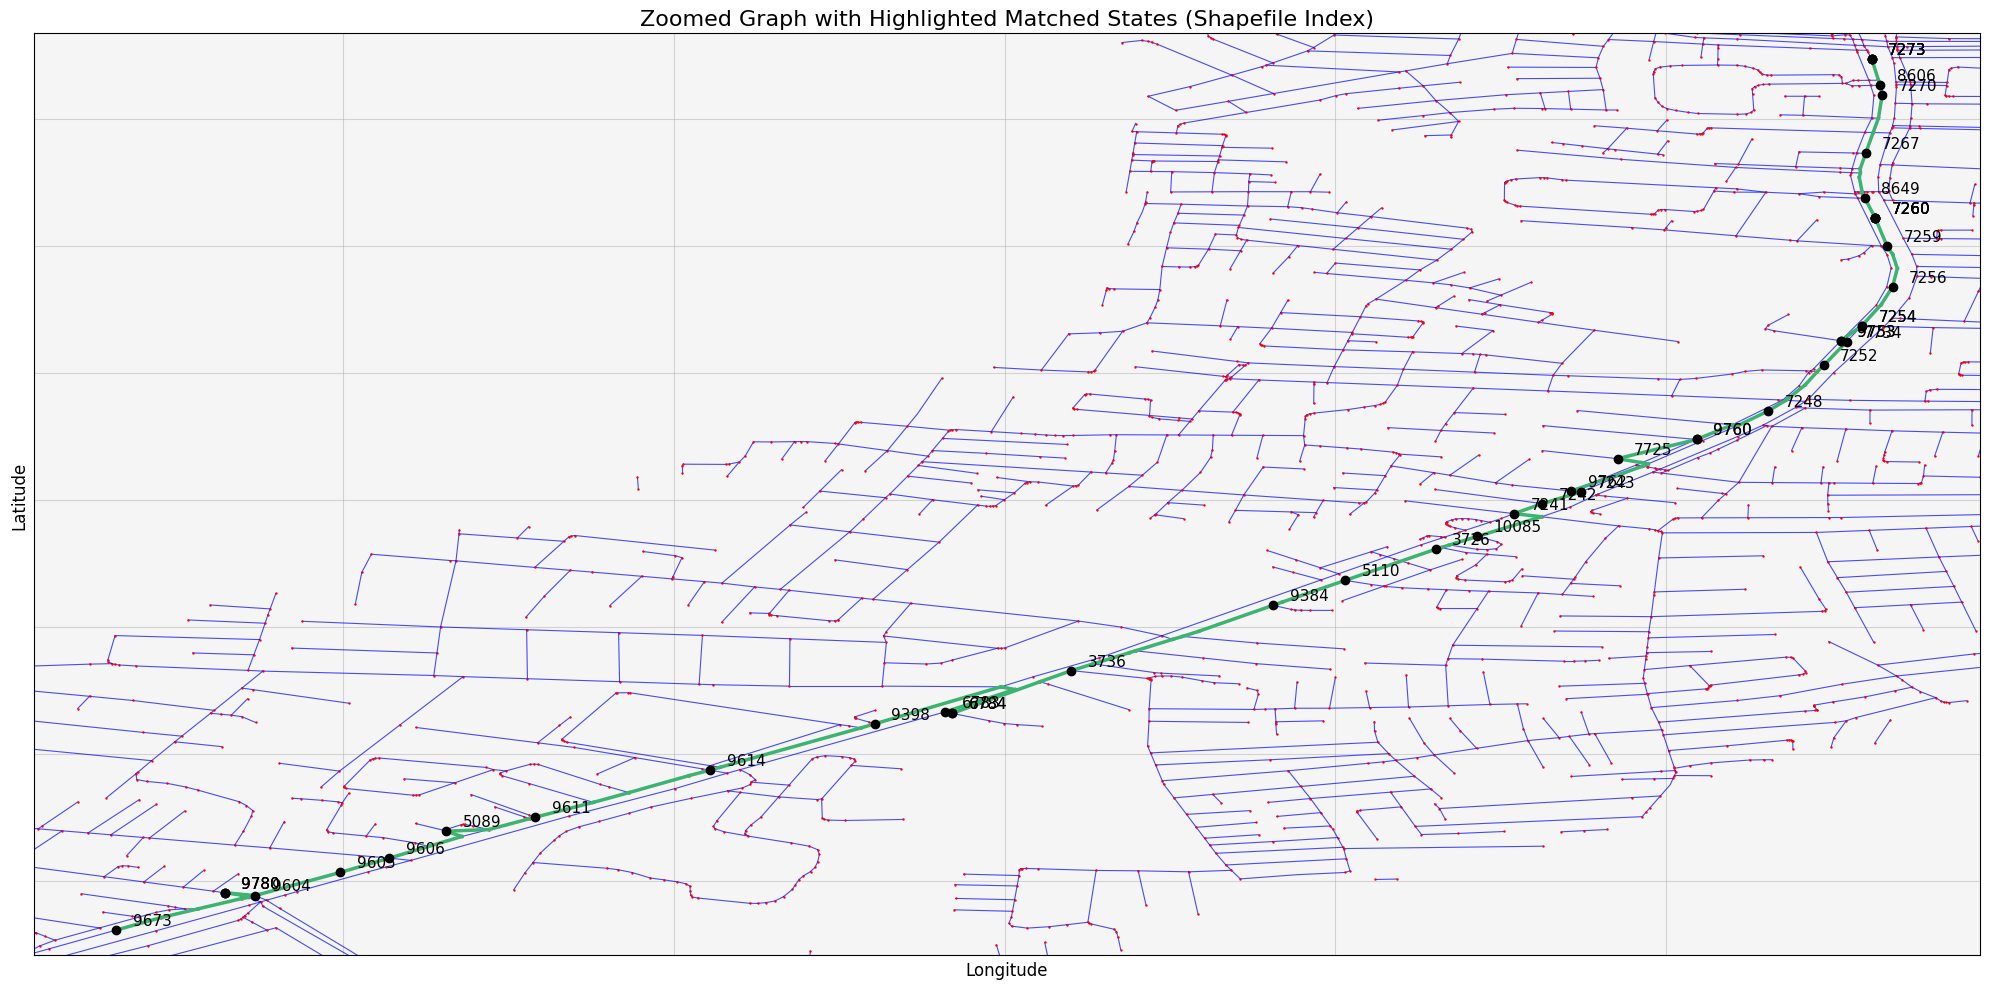

In [47]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos]
valid_highlighted_nodes_2 = [node for node in valid_highlighted_nodes_2 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_2) > 2:
    path_nodes_2 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_2)
else:
    path_nodes_2 = valid_highlighted_nodes_2

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_2)

fig, ax = plt.subplots(figsize=(20, 10))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_2:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_2) - 1):
    start = path_nodes_2[i]
    end = path_nodes_2[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)
x_coords = [coord[0] for coord in path_nodes_2]
y_coords = [coord[1] for coord in path_nodes_2]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+-------------+-----------------+
|   Path Length |    Geodesic |   distance_diff |
+===============+=============+=================+
|     131.041   |  99.92      |      31.1212    |
+---------------+-------------+-----------------+
|       0       |   2.49521   |       2.49521   |
+---------------+-------------+-----------------+
|       0       |   4.76951   |       4.76951   |
+---------------+-------------+-----------------+
|      20.8976  |  25.8844    |       4.98682   |
+---------------+-------------+-----------------+
|      75.4982  |  62.6403    |      12.8579    |
+---------------+-------------+-----------------+
|      44.7273  |  45.7891    |       1.06181   |
+---------------+-------------+-----------------+
|      82.2676  |  68.5336    |      13.734     |
+---------------+-------------+-----------------+
|      68.9034  |  85.4461    |      16.5426    |
+---------------+-------------+-----------------+
|     153.804   | 138.847     |      14.9569    |


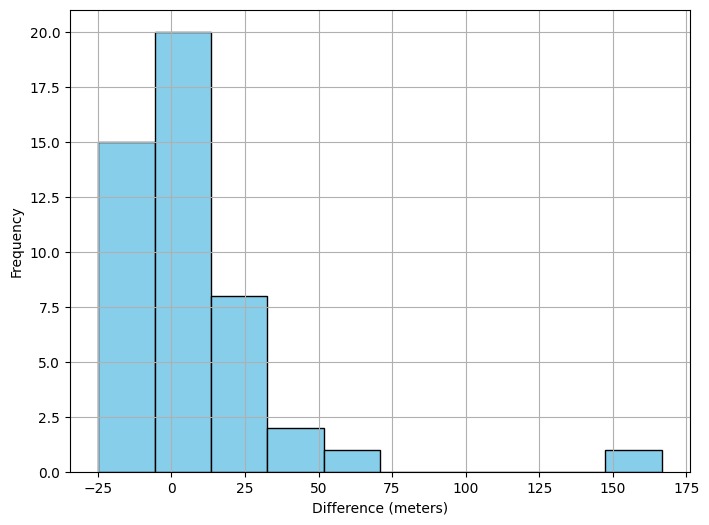

In [48]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_2_2 = []
distances_2 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

gpx_coordinates_path = [(lat, lon) for lon, lat in path_nodes_2]
consecutive_distances_km_2, total_distance = calculate_consecutive_geodesic_distances(gpx_coordinates_path, distances_2)

valid_highlighted_indices = [path_nodes_2.index(node) for node in valid_highlighted_nodes_2 if node in path_nodes_2]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_2[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

gpx_coordinates_obs = [(lat, lon) for lon, lat in observations_2_no_duplicates]
consecutive_distances_km_2, _ = calculate_consecutive_geodesic_distances(gpx_coordinates_obs, distances_2_2)

data = []
for i in range(max(len(highlighted_distances), len(distances_2_2))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_2_2[i] if i < len(distances_2_2) else "", 
        abs(highlighted_distances[i] - distances_2_2[i]) if i < len(highlighted_distances) and i < len(distances_2_2) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_2_2):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_2_2), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_2_2 arrays have different lengths. Cannot compute differences.")


In [49]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_2_2))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_2_2[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)


+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|      10 |           193.413 |        26.7755 |             166.638 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[10]


Total distance of the shortest path: 1626.64 meters
Total geodesic distance : 2372.87 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5626794, 12.8888895)  (77.5626279, 12.8890332)               9673
          1  (77.5632659, 12.8895857)  (77.5632832, 12.8897687)               9780
          2  (77.5632643, 12.8895632)  (77.5632832, 12.8897687)               9780
          3  (77.5633062, 12.8895762)  (77.5632832, 12.8897687)               9780
          4  (77.5634869, 12.8897289)  (77.5634669, 12.8897121)               9604
          5  (77.5639271, 12.8900951)  (77.5639838, 12.8901688)               9605
          6  (77.5642104, 12.8904018)  (77.56428, 12.8904499)                 9606
          7  (77.5646703, 12.8908263)  (77.5646232, 12.8909782)               5089
          8  (77.5652

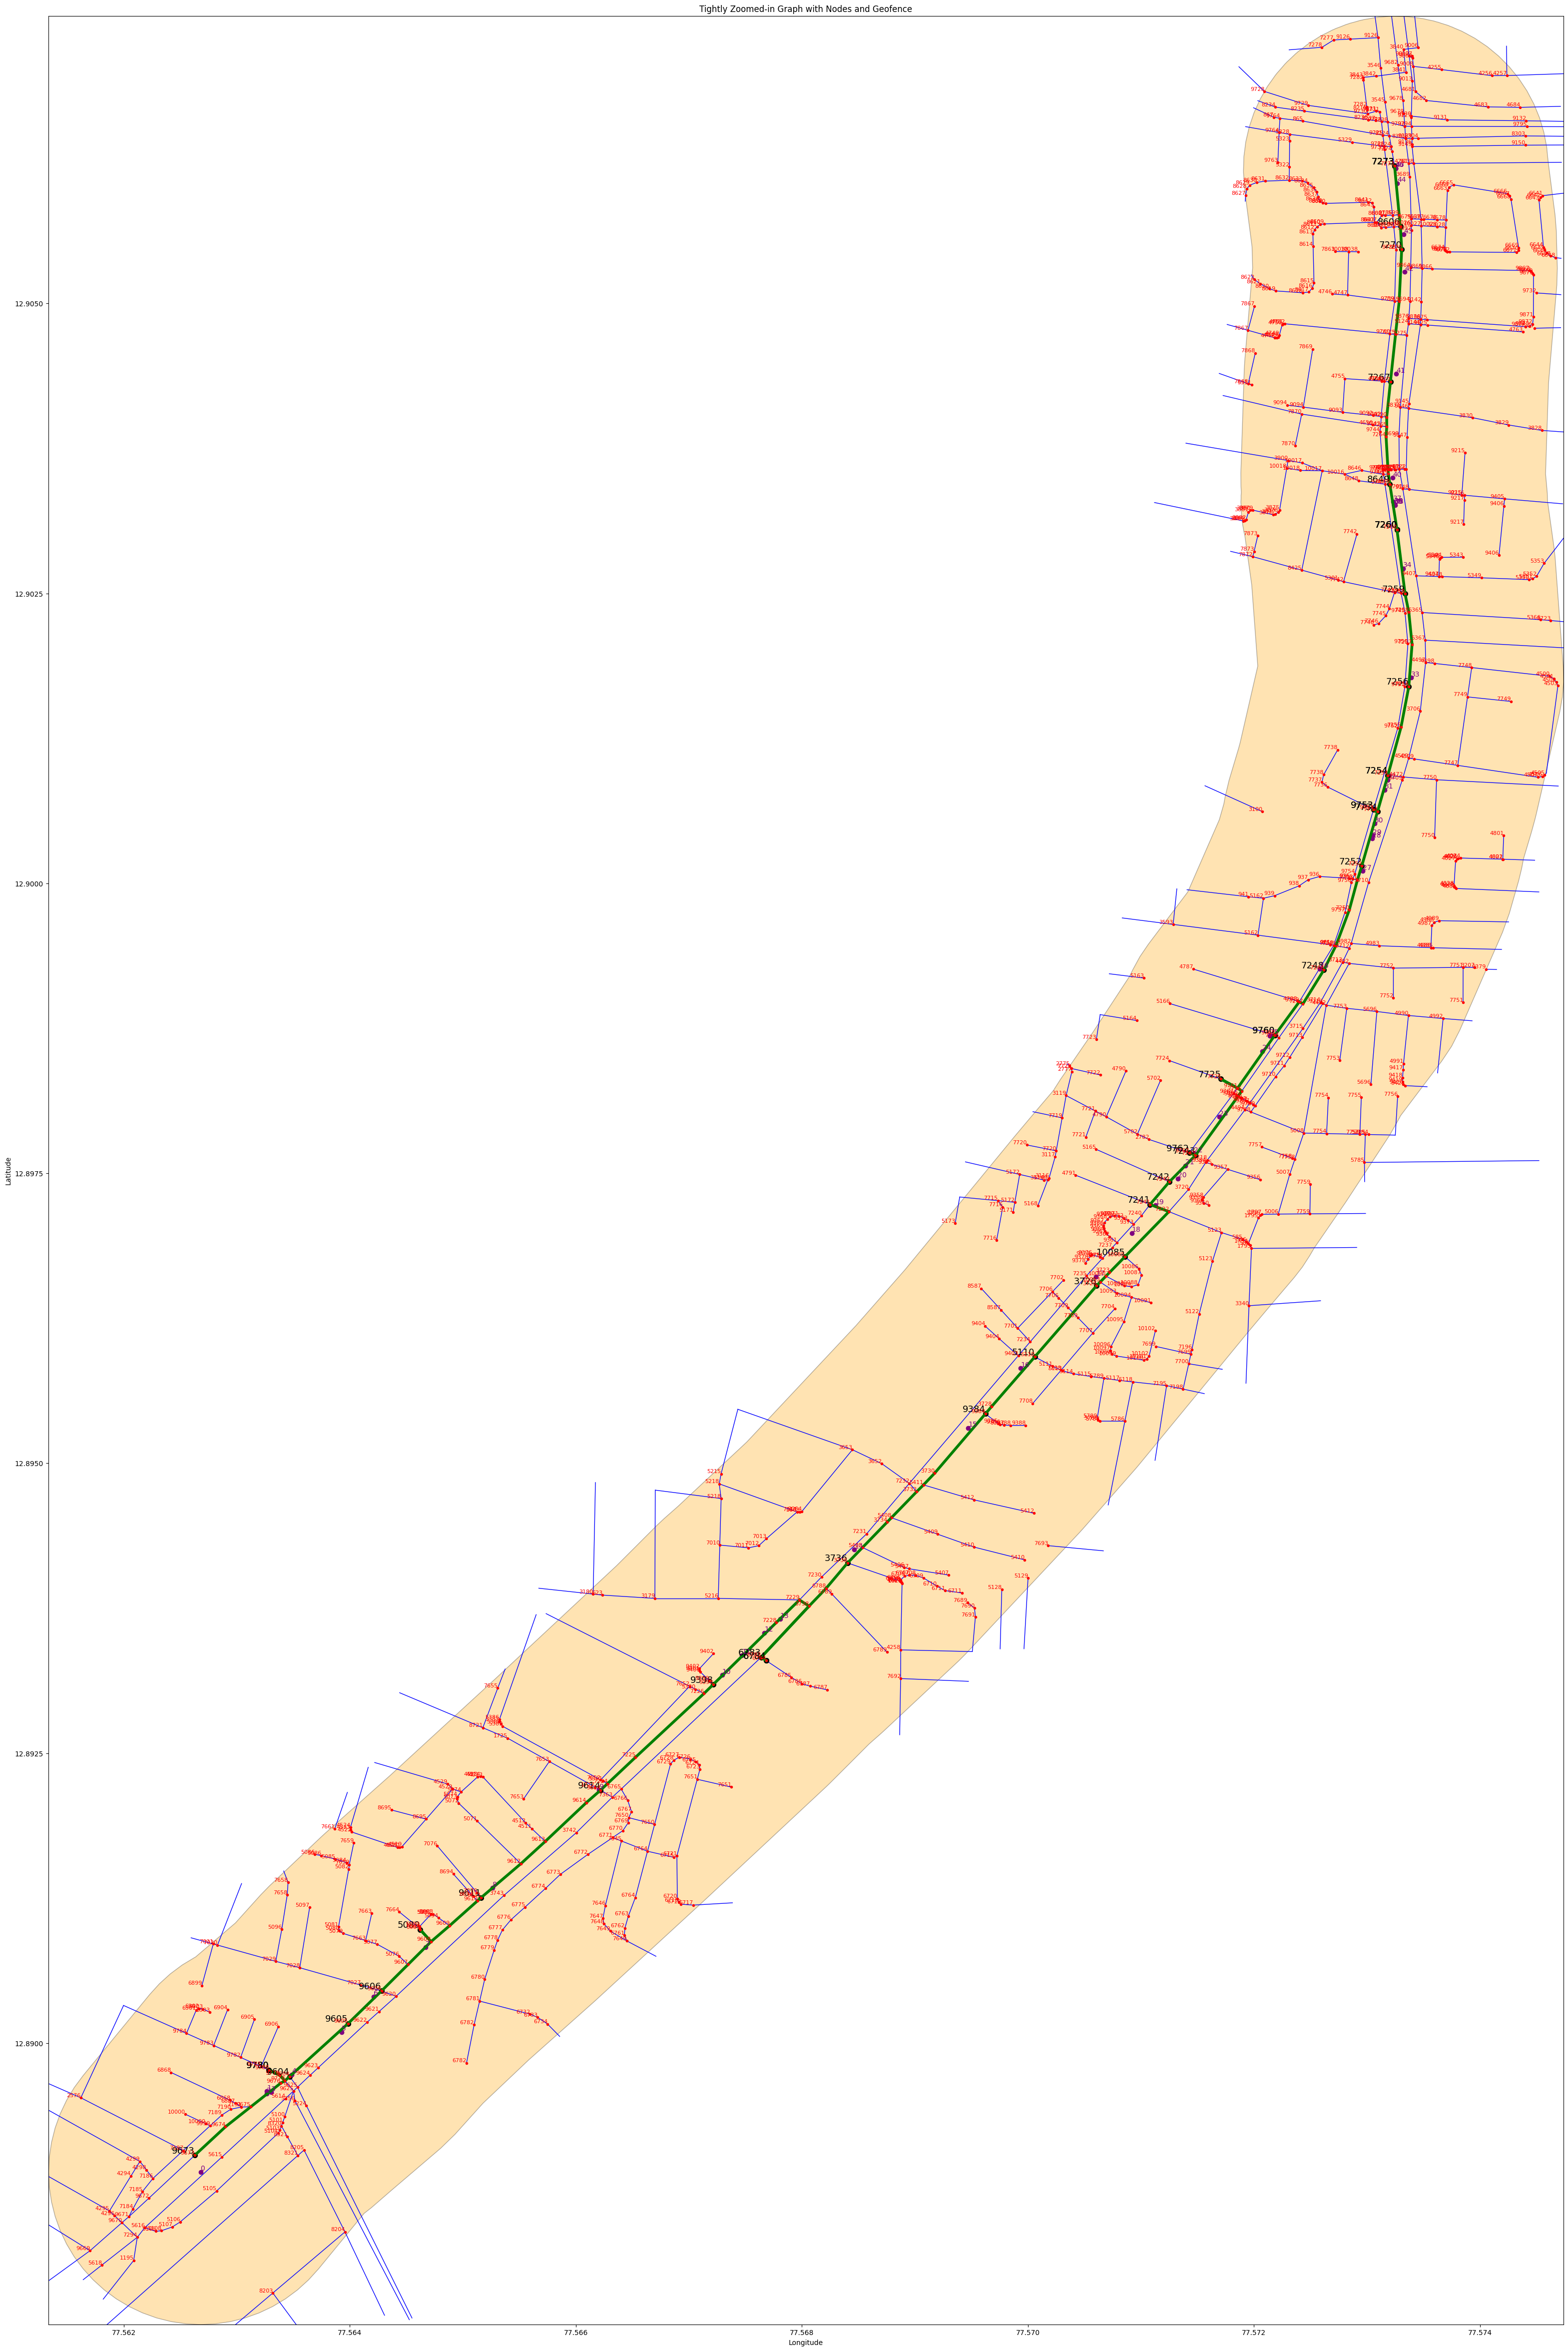

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate


fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2_2 = 59
end_index_2_2 = 120

observations_2 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_2_2 <= i < end_index_2_2
]

observations_2_no_duplicates = [pt for i, pt in enumerate(observations_2) if i == 0 or pt != observations_2[i - 1]]

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    nodes_in_geofence = [node for node, position in pos_2.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_2.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_2[u], pos_2[v]))

    fig, ax = plt.subplots(figsize=(50, 60))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos_2]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_2 if Point(pos_2[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    # Plot geofence
    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    # Segment-wise path plotting and distance
    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_2, start, end):
            path = shortest_path_geodesic_weight(subgraph_2, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_2[node_start], pos_2[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_2[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    # Total distances
    gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(gpx_coordinates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    # Node indexing in geofence
    for node in nodes_in_geofence:
        x, y = pos_2[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    # --- Added Table Printing Section ---
    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    # Final plot limits and display
    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Candidate idx: 9604, Angle Difference: 4.45°, Distance Difference: 0.0275 km
Candidate idx: 7191, Angle Difference: 2.11°, Distance Difference: 0.0023 km
Candidate idx: 6867, Angle Difference: 0.80°, Distance Difference: 0.0041 km
Candidate idx: 6868, Angle Difference: 3.62°, Distance Difference: 0.0088 km
Candidate idx: 9781, Angle Difference: 1.34°, Distance Difference: 0.0466 km

Top 5 candidate node numbers for observation 1: [7190, 9780, 6867, 9781, 7191]
Reassigned: original 9780 → new index: 7190, angle: 0.66°, dist: 8.26 m
Candidate idx: 1727, Angle Difference: 0.58°, Distance Difference: 0.0180 km
Candidate idx: 9614, Angle Difference: 0.22°, Distance Difference: 0.0126 km
Candidate idx: 6765, Angle Difference: 1.67°, Distance Difference: 0.0332 km
Candidate idx: 7363, Angle Difference: 1.78°, Distance Difference: 0.0243 km
Candidate idx: 3742, Angle Difference: 2.77°, Distance Difference: 0.0606 km

Top 5 candidate node numbers for observation 9: [7225, 9614, 7224, 9614, 5391

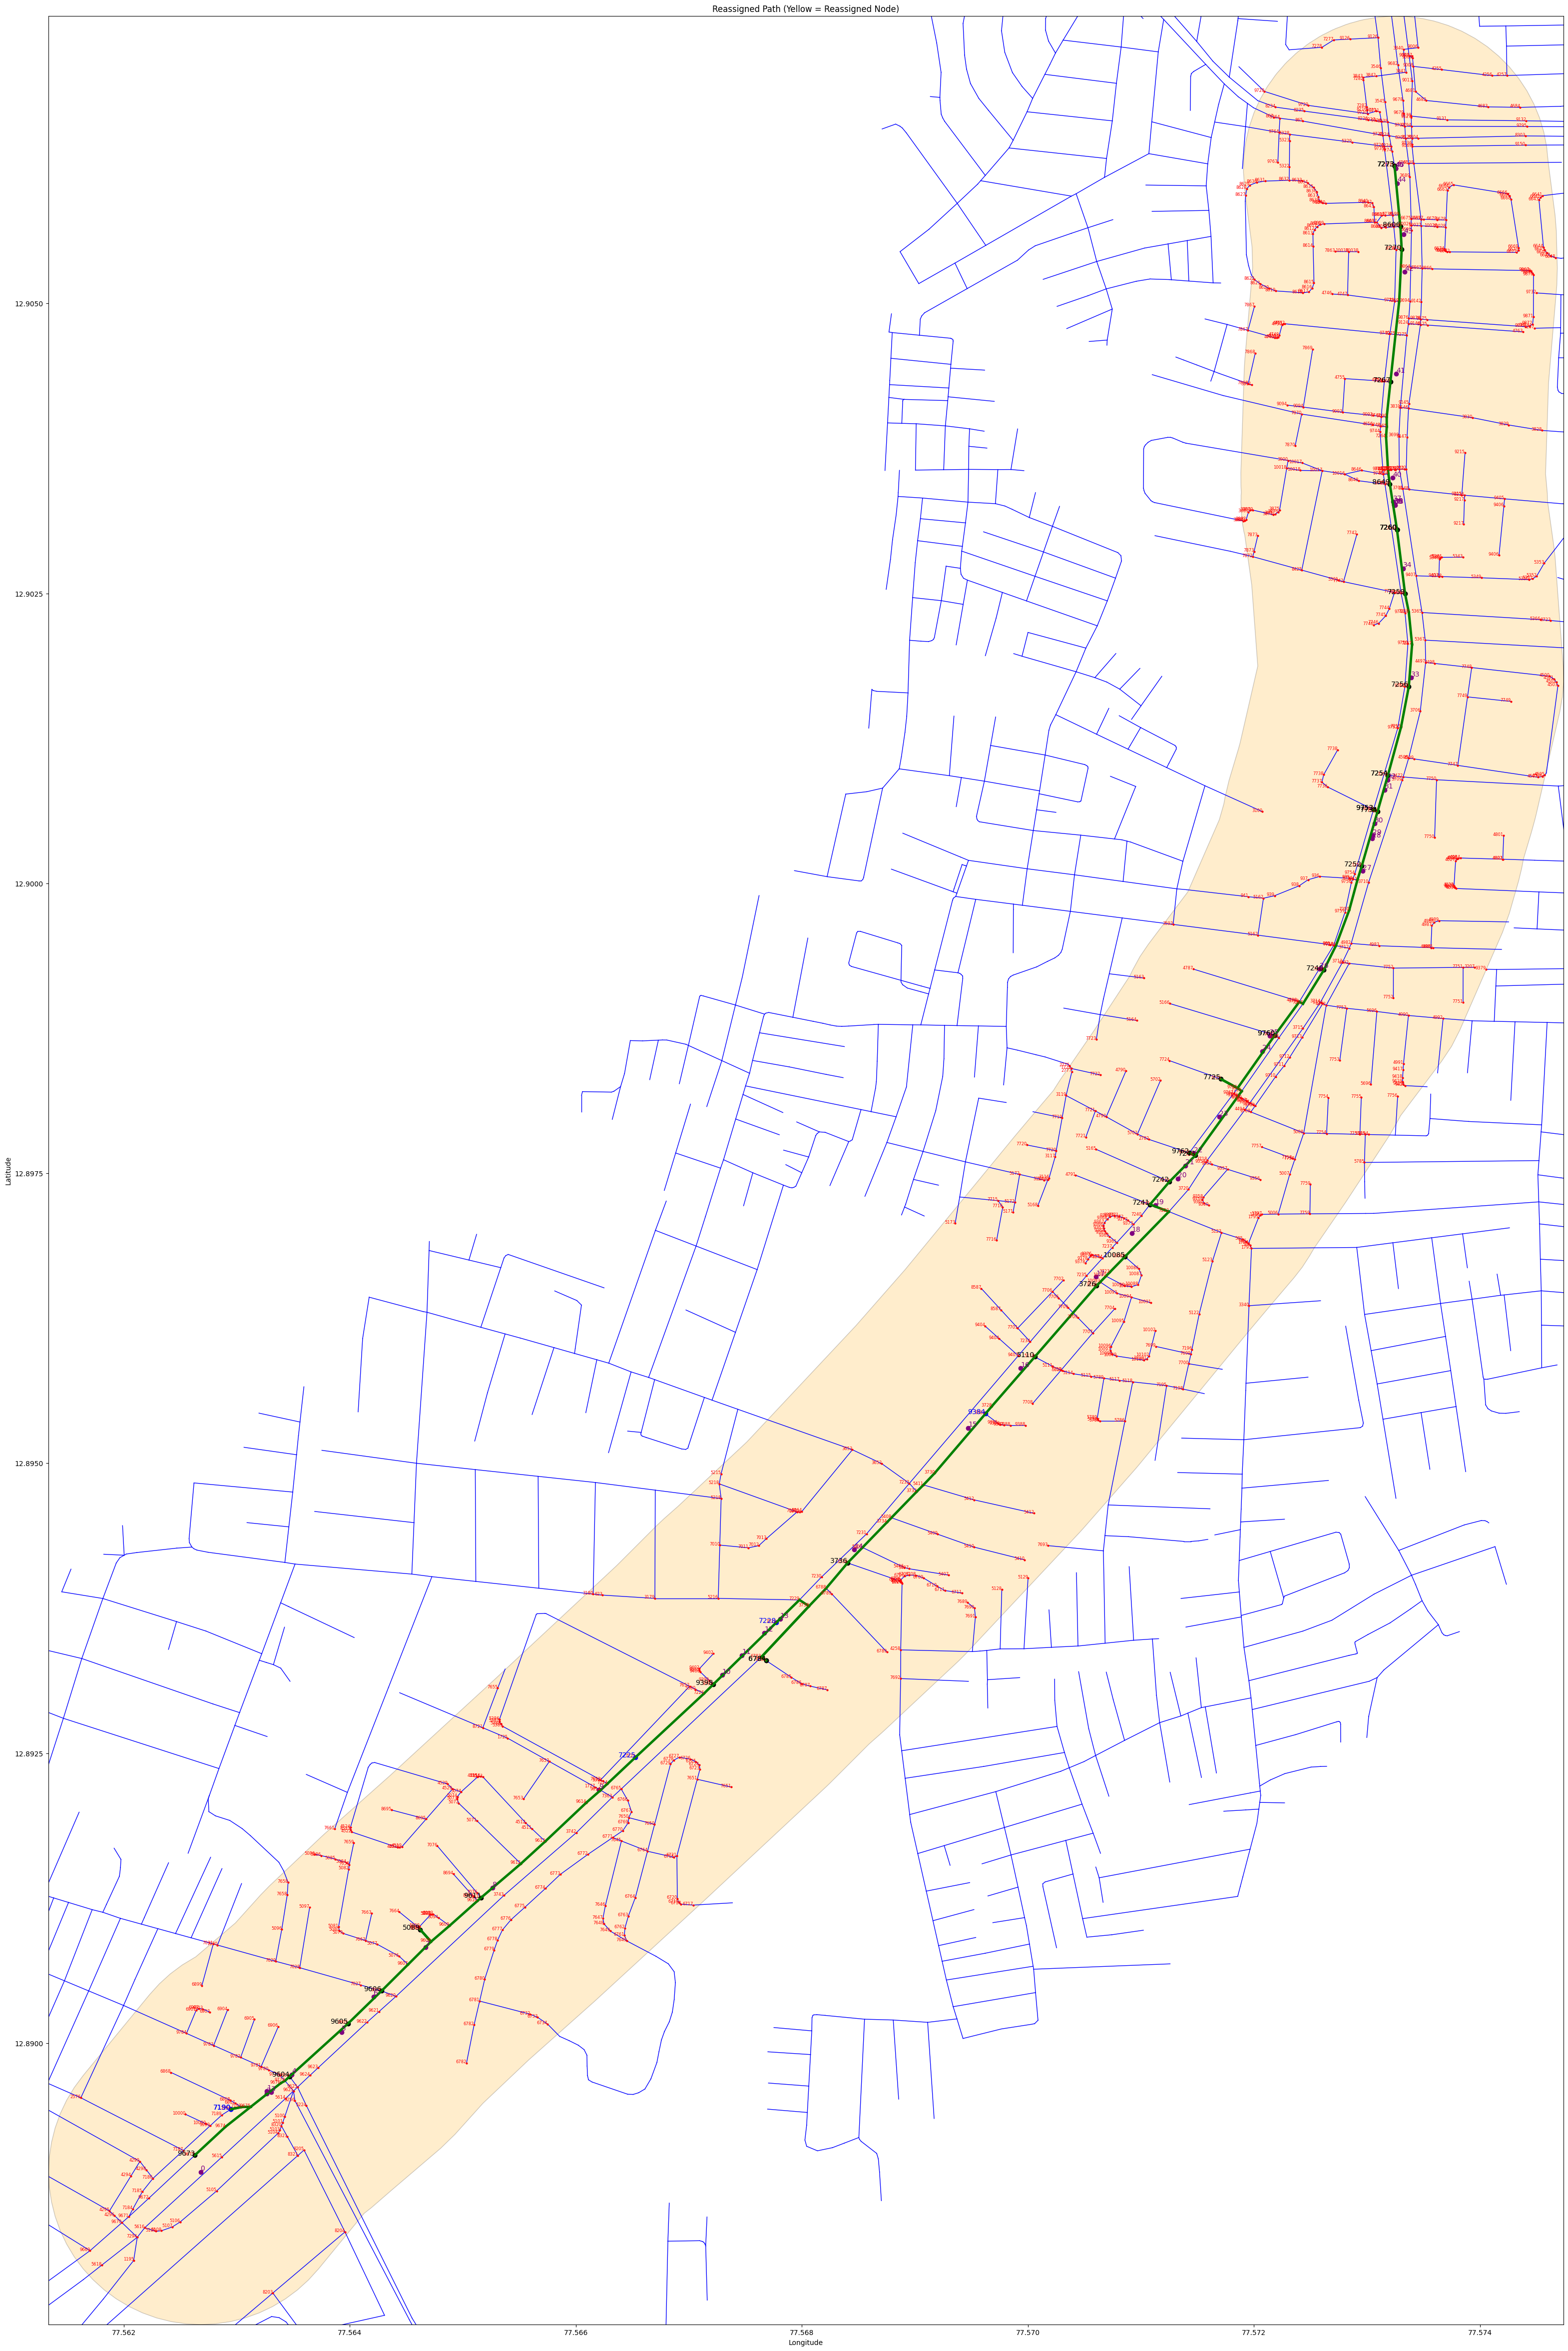

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 59
end_index = 120

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]

gpx_path = LineString(observations_2_no)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
geofence = geofence_buffered_3857.to_crs(epsg=4326)  

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lat1, lon1 = map(math.radians, p1)
        lat2, lon2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.07:  
                candidates.append((angle_difference, dist_difference, candidate))
        for cand in candidates[:5]:
            print(f"Candidate idx: {coord_to_index.get(cand[2], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        if candidates:
            candidates.sort(key=lambda x: (x[0], x[1]))
            print(f"\nTop 5 candidate node numbers for observation {i}: {[coord_to_index.get(c[2], 'N/A') for c in candidates[:5]]}")
            best_candidate = candidates[0]
            return best_candidate[2], best_candidate  
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_2[0])]
    reassigned_log = []
    reassignment_memory = {}

    for i in range(1, min(len(matched_coordinates_2), len(observations_2_no_duplicates))):
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_2[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
            _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
            if dist <= 0.1:
                reassigned_nodes.append(target_node)
                continue

        obs_heading = calculate_heading(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i])
        reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
        if reassigned:
            reassigned_nodes.append(reassigned)
            idx = coord_to_index.get(reassigned, "N/A")
            reassignment_memory[original_index] = reassigned
            print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
            reassigned_log.append((target_node, reassigned, idx, candidate_info))
        else:
            reassigned_nodes.append(fixed_node)
            idx = coord_to_index.get(fixed_node, "N/A")
            print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no_duplicates[i]}")

    fig, ax = plt.subplots(figsize=(50, 60))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [54]:
from tabulate import tabulate
mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_2_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))



Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5626794, 12.8888895)  (77.5626279, 12.8890332)               9673
          1  (77.5632659, 12.8895857)  (77.562947, 12.8894301)                7190
          2  (77.5632643, 12.8895632)  (77.562947, 12.8894301)                7190
          3  (77.5633062, 12.8895762)  (77.562947, 12.8894301)                7190
          4  (77.5634869, 12.8897289)  (77.5634669, 12.8897121)               9604
          5  (77.5639271, 12.8900951)  (77.5639838, 12.8901688)               9605
          6  (77.5642104, 12.8904018)  (77.56428, 12.8904499)                 9606
          7  (77.5646703, 12.8908263)  (77.5646232, 12.8909782)               5089
          8  (77.5652602, 12.8913378)  (77.565162, 12.8912551)                9611
          9  (77.5662051, 12.8921839)  (

In [55]:
from tabulate import tabulate
print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_2_no_duplicates)):
    obs1 = observations_2_no_duplicates[i - 1]
    obs2 = observations_2_no_duplicates[i]
    geod = geodesic(obs1[::-1], obs2[::-1]).meters  

    matched1 = tuple(matched_coordinates_2[i - 1])
    matched2 = tuple(matched_coordinates_2[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            9780 │               7190 │        99.92   │           106.481  │               75.8435 │                     6.5612 │                       24.0765 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            9780 │               7190 │      